In [1]:
from glob import glob
import h5py
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import umap
import umap.plot

## Data Loadings

In [2]:
directory = f'/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/NIRCAM/'

In [3]:
h5_files = glob(os.path.join(directory,'**/*.h5'))

In [4]:
h5_files

['/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/NIRCAM/1441/1441__psfstack_sci.h5',
 '/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/NIRCAM/1386/1386__psfstack_sci.h5']

In [5]:
data_1441 = h5py.File(h5_files[0],'r')
data_1386 = h5py.File(h5_files[1],'r')

In [6]:
def visualize(flatten_final, approximation, ncols=10):
    substract = np.abs(flatten_final[:10,:] - approximation)
    nsample = flatten_final.shape[0]
    #subs_mean = np.mean(substract,axis=0)
    
    _, axes = plt.subplots(nrows=3,ncols=ncols,figsize=(20,8))
    
    for idx in range(ncols):
        
        #rand_num = np.random.randint(0,nsample)
        #print(rand_num)
        
        
        axes[0][idx].imshow(flatten_final[idx].reshape(320, 320),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
        axes[1][idx].imshow(approximation[idx].reshape(320, 320),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
    
        axes[2][idx].imshow(np.sinh(substract[idx]).reshape(320, 320),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
        
        if idx == 0:
            
            axes[0][idx].set_ylabel('Original',fontsize=10,fontweight='bold')
            axes[1][idx].set_ylabel('Reconstructed',fontsize=10,fontweight='bold')
            axes[2][idx].set_ylabel('Residuals',fontsize=10,fontweight='bold')
            
        axes[0][idx].set_yticks([])
        axes[0][idx].set_xticks([])
        
        axes[1][idx].set_yticks([])
        axes[1][idx].set_xticks([])
        
        axes[2][idx].set_yticks([])
        axes[2][idx].set_xticks([])
        
    plt.subplots_adjust(wspace=0,hspace=0)
    _.patch.set_facecolor('#423f3b')
    plt.show()
    

# Methods

We will try two methods for non-linear dimension reduction:
 - UMAP
 - T-SNE

# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:
 - The data is uniformly distributed on Riemannian manifold
 - The Riemannian metric is locally constant (or can be approximated as such)
 - The manifold is locally connected

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

## 1386

In [7]:
def map_1386_classes(n):
    
    if n == 0:
        return 'F410M'
    elif n == 1:    
        return 'F250M'
    elif n == 2:
        return 'F444W'
    elif n == 3:
        return 'F300M'
    elif n == 4:
        return 'F356W'
    
        
    

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


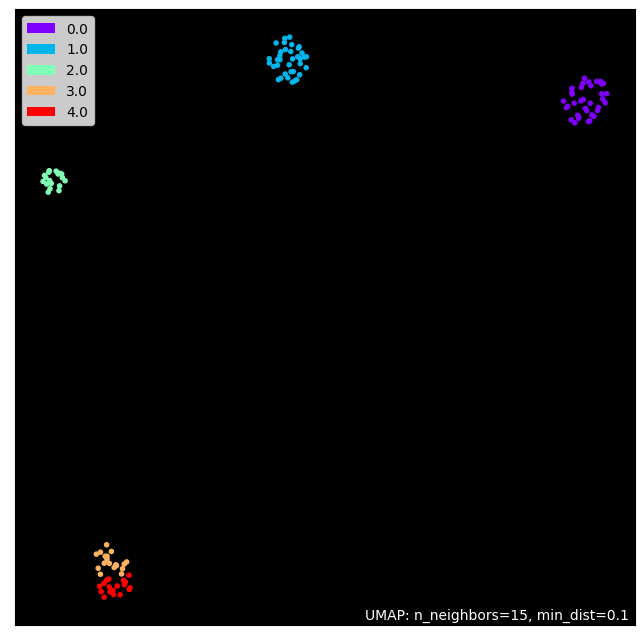

In [8]:
keys_1386 = [x for x in data_1386.keys()]
final_1386 = np.concatenate((np.array(data_1386[keys_1386[0]]),np.array(data_1386[keys_1386[1]])))

for i in range(len(keys_1386)-2):
    
    final_1386 = np.concatenate((final_1386,np.array(data_1386[keys_1386[i+2]])))
    

flatten_final_1386 = np.resize(final_1386, (final_1386.shape[0],320*320))
mapper_1386 = umap.UMAP().fit(flatten_final_1386)

q = np.zeros(36)
w = np.ones(36)
r = np.ones(18) * 2
t = np.ones(18) * 3
y = np.ones(18) * 4

classes_1386 = np.hstack((q, w, r, t, y))
detector_classes_1386 = np.array(map(map_1386_classes,classes_1386))

umap.plot.points(mapper_1386,labels=classes_1386,theme='fire',background='black');

/tmp/ipykernel_105111/2521500341.py:21: RuntimeWarning: overflow encountered in sinh
  axes[2][idx].imshow(np.sinh(substract[idx]).reshape(320, 320),


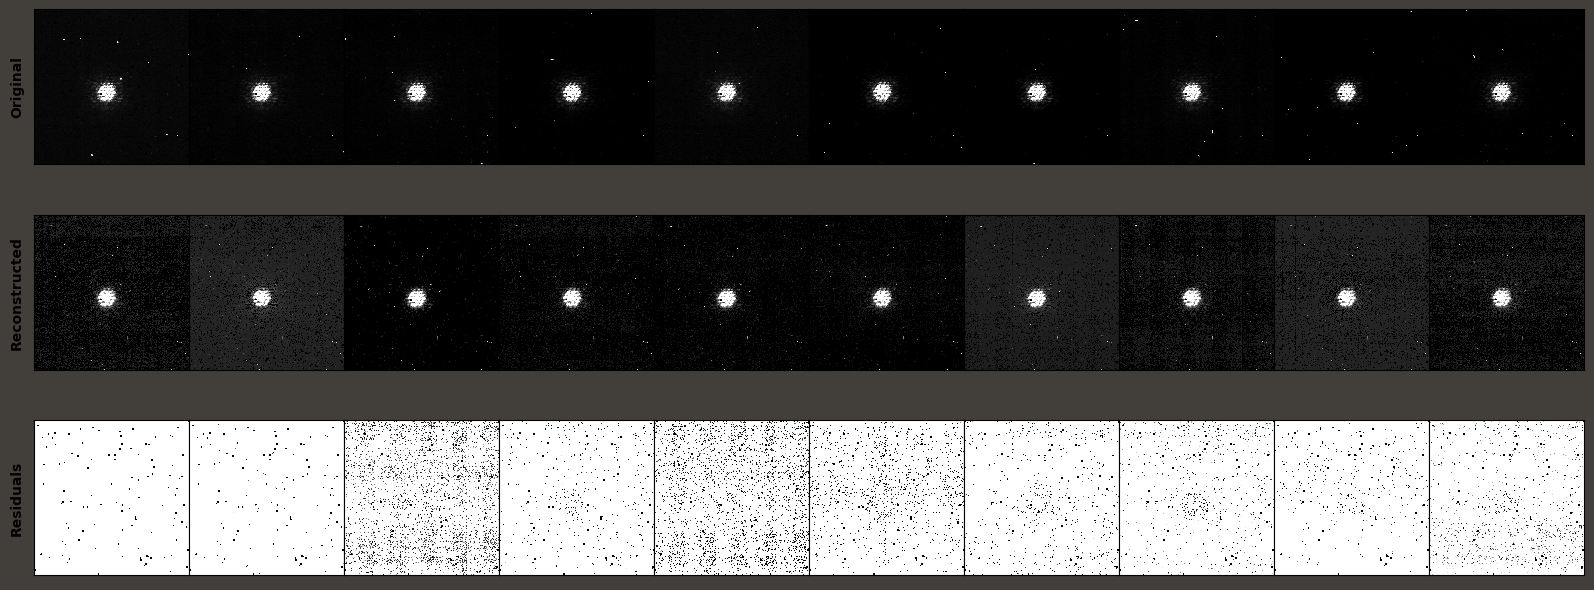

In [9]:
test_1386 = mapper_1386.embedding_[:10,:]
reconstruct_umap_1386 = mapper_1386.inverse_transform(test_1386)
visualize(flatten_final_1386,reconstruct_umap_1386)

## 1441

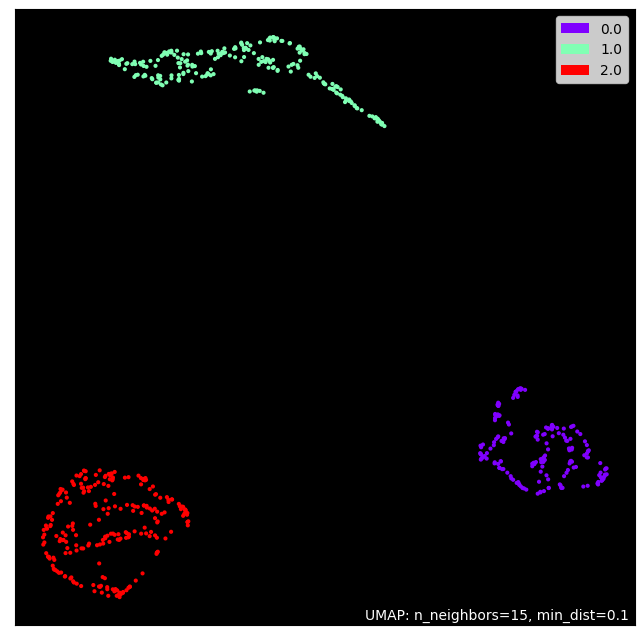

In [10]:
keys_1441 = [x for x in data_1441.keys()] # get list of keys for each psfstack
f = np.concatenate((np.array(data_1441[keys_1441[0]]),np.array(data_1441[keys_1441[1]]))) 
final_1441 = np.concatenate((f,np.array(data_1441[keys_1441[2]])))
flatten_final_1441 = np.resize(final_1441, (final_1441.shape[0],320*320))
mapper_1441 = umap.UMAP().fit(flatten_final_1441)

a = np.zeros(189) # class0
b = np.ones(240)  # class1
c = np.ones(240) * 2 # class2

classes_1441 = np.hstack((a, b, c))

umap.plot.points(mapper_1441,labels=classes_1441,theme='fire',background='black');

/tmp/ipykernel_105111/2521500341.py:21: RuntimeWarning: overflow encountered in sinh
  axes[2][idx].imshow(np.sinh(substract[idx]).reshape(320, 320),


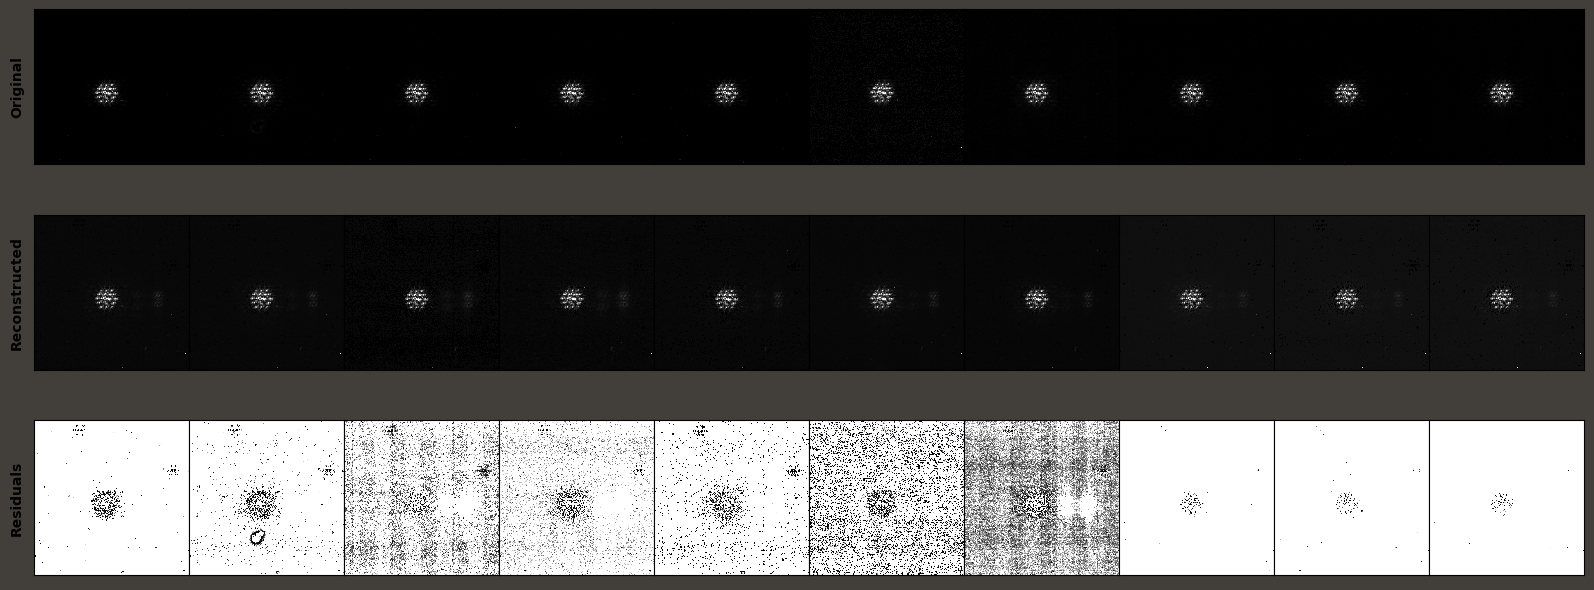

In [12]:
test_1441 = mapper_1441.embedding_[:10,:]
reconstruct_umap_1441 =mapper_1441.inverse_transform(test_1441)
visualize(flatten_final_1441,reconstruct_umap_1441)

----

# T-SNE (T-distributed Stochastic Neighbor Embedding)

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

# TSNE 1386 Visualization

In [14]:
tsne_1386 = TSNE()
tsne_latent_1386 = tsne_1386.fit_transform(flatten_final_1386)

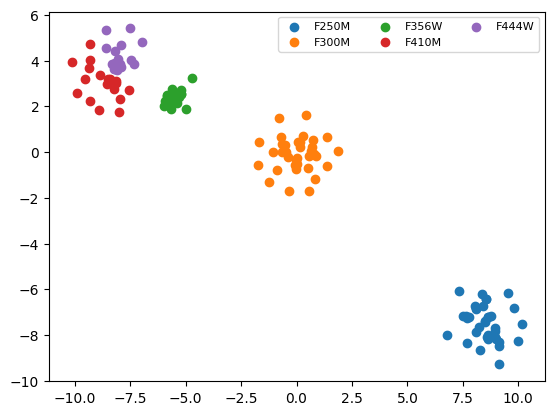

In [16]:
f250m = plt.scatter(tsne_latent_1386[:36,0], tsne_latent_1386[:36,1])
f300m = plt.scatter(tsne_latent_1386[36:72,0], tsne_latent_1386[36:72,1])
f356w  = plt.scatter(tsne_latent_1386[72:90,0], tsne_latent_1386[72:90,1])
f410m  = plt.scatter(tsne_latent_1386[90:108,0], tsne_latent_1386[90:108,1])
f444w  = plt.scatter(tsne_latent_1386[108:,0], tsne_latent_1386[108:,1])

plt.legend((f250m, f300m, f356w, f410m, f444w),
           ('F250M', 'F300M', 'F356W', 'F410M', 'F444W'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)

# TSNE 1441 Visualization 

In [17]:
tsne_1441 = TSNE()
tsne_latent_1441 = tsne_1441.fit_transform(flatten_final_1441)

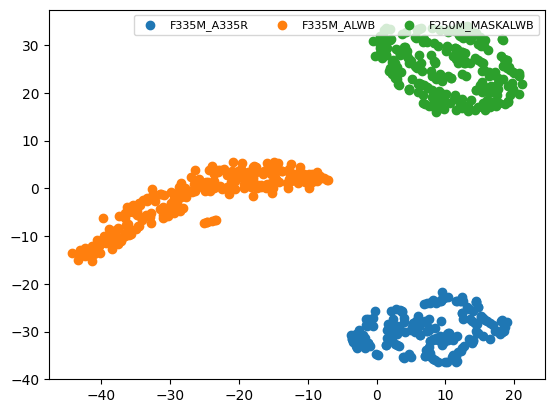

In [18]:
f335m_a335r    = plt.scatter(tsne_latent_1441[:189,0], tsne_latent_1441[:189,1])
f335m_alwb     = plt.scatter(tsne_latent_1441[189:429,0], tsne_latent_1441[189:429,1])
f250m_maskalwb = plt.scatter(tsne_latent_1441[429:,0], tsne_latent_1441[429:,1])

plt.legend((f335m_a335r, f335m_alwb, f250m_maskalwb),
           ('F335M_A335R', 'F335M_ALWB', 'F250M_MASKALWB'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8);

As expected non-linear models have more interpretable and more explainable components rather than the linear models that we applied in the other notebook